In [1]:
import json
import os

import pandas as pd
import numpy as np

from collections import defaultdict
from tqdm import tqdm

import sccellfie
import anndata as ad
import scanpy as sc

import matplotlib.pyplot as plt
import seaborn as sns
import textwrap

In [2]:
import mpl_fontkit as fk
fk.install("Lato")
fk.set_font("Lato")

Font name: `Lato`


In [3]:
# Set the directory where figures are saved
sc.settings.figdir = './Paper-Figures/'

# Set the default figure size (width, height) in inches
sc.settings.figsize = (1,1)  # or any other size you prefer

# Set the default DPI (dots per inch) for figure quality
sc.settings.dpi = 300  # Higher values for higher resolution

# Set the DPI for saving figures (can be different from display DPI)
sc.settings.dpi_save = 400

# Set vector graphics format (pdf, svg, etc.)
sc.settings.file_format_figs = 'pdf'

In [30]:
os.makedirs(sc.settings.figdir)

## Load Data

### Tissue Labels

In [4]:
labels = pd.read_excel('CELLxGENE-Labels.xlsx')
labels['Organ/System'] = [idx.title() for idx in labels['Organ/System'].values]
labels = labels.rename(columns={'Organ/System' : 'Tissue'})

In [5]:
labels['tissue'] = labels['Tissue'].apply(lambda x: x.lower().replace(' ', '_'))

In [6]:
labels.head()

Tissue               Label  Cell Number  Cell Type Number  \
0  Adipose Tissue   Connective tissue       252364               NaN   
1   Adrenal Gland           Endocrine       437889               NaN   
2         Bladder             Urinary        33631               NaN   
3           Blood  Circulatory system      4938374               NaN   
4     Bone Marrow       Immune system       296739               NaN   

           tissue  
0  adipose_tissue  
1   adrenal_gland  
2         bladder  
3           blood  
4     bone_marrow

In [7]:
label_map = labels.set_index('tissue')['Label'].to_dict()

### Min and Max values per metabolic tasks across all CELLxGENE atlas

In [8]:
min_max = pd.read_csv('./Processed-Results-V042/CELLxGENE-Metabolic-Tasks-MinMax.csv', index_col=0)

In [9]:
min_max.head()

(R)-3-Hydroxybutanoate synthesis  \
single_cell_min                          0.000000   
single_cell_max                          7.419829   
cell_type_min                            0.041299   
cell_type_max                            4.403184   

                 3'-Phospho-5'-adenylyl sulfate synthesis  \
single_cell_min                                  0.000000   
single_cell_max                                 11.795217   
cell_type_min                                    0.000000   
cell_type_max                                    4.105401   

                 AMP salvage from adenine  \
single_cell_min                  0.000000   
single_cell_max                 20.651447   
cell_type_min                    0.000000   
cell_type_max                    5.187688   

                 ATP generation from glucose (hypoxic conditions) - glycolysis  \
single_cell_min                                           0.000000               
single_cell_max                                          13.613079               
cell_type_min                                             0.033310               
cell_type_max                                             7.840590               

                 ATP regeneration from glucose (normoxic conditions) - glycolysis + krebs cycle  \
single_cell_min                                           0.000000                                
single_cell_max                                           4.979552                                
cell_type_min                                             0.024252                                
cell_type_max                                             3.159272                                

                 Acetoacetate synthesis  Alanine degradation  \
single_cell_min                0.000000             0.000000   
single_cell_max                8.038148             3.030361   
cell_type_min                  0.023852             0.028060   
cell_type_max                  4.670686             1.874831   

                 Alanine synthesis  Arachidonate degradation  \
single_cell_min           0.000000                  0.000000   
single_cell_max           7.951063                  1.752682   
cell_type_min             0.025760                  0.000000   
cell_type_max             4.480565                  0.854841   

                 Arachidonate synthesis  ...  Valine to succinyl-coA  \
single_cell_min                0.000000  ...                0.000000   
single_cell_max                4.296328  ...                6.424888   
cell_type_min                  0.021624  ...                0.000000   
cell_type_max                  2.594763  ...                1.313472   

                 Vesicle secretion  beta-Alanine degradation  \
single_cell_min           0.000000                  0.000000   
single_cell_max           2.780753                  2.980583   
cell_type_min             0.000000                  0.025981   
cell_type_max             0.798270                  1.899791   

                 beta-Alanine synthesis  cis-vaccenic acid degradation  \
single_cell_min                0.000000                       0.000000   
single_cell_max                6.203485                       2.161476   
cell_type_min                  0.029364                       0.000000   
cell_type_max                  3.463882                       1.151658   

                 cis-vaccenic acid synthesis  gamma-Linolenate degradation  \
single_cell_min                     0.000000                      0.000000   
single_cell_max                     4.050148                      2.341566   
cell_type_min                       0.013848                      0.000000   
cell_type_max                       2.225383                      1.263210   

                 gamma-Linolenate synthesis  glyco-cholate synthesis  \
single_cell_min                    0.000000                 0.000000   
single_cell_max                    7.578767                 2.982760   
cell_type_

### CELLxGENE results per cell type

In [10]:
cellxgene = pd.read_csv('./Processed-Results-V042/CELLxGENE-Metabolic-Tasks-MeltedResults.csv')

In [11]:
# Create a mapping dictionary from the min_max dataframe
min_values = min_max.loc['cell_type_min'].to_dict()
max_values = min_max.loc['cell_type_max'].to_dict()

# Apply the mapping in a vectorized way
cellxgene['min_value'] = cellxgene['metabolic_task'].map(min_values)
cellxgene['max_value'] = cellxgene['metabolic_task'].map(max_values)

# Perform the calculation
cellxgene['scaled_trimean'] = (cellxgene['trimean'] - cellxgene['min_value']) / (cellxgene['max_value'] - cellxgene['min_value'])

# Clean up intermediate columns if desired
cellxgene = cellxgene.drop(['min_value', 'max_value'], axis=1)

In [12]:
cellxgene = cellxgene[['metabolic_task', 'tissue', 'cell_type', 'trimean', 'scaled_trimean', 'variance', 'std', 'n_cells_threshold', 'n_cells_nonzero', 'total_cells']]

In [13]:
cellxgene.to_csv('./Processed-Results-V042/CELLxGENE-Metabolic-Tasks-MeltedResults-Scaled.csv', index=False)

In [14]:
cellxgene['label'] = cellxgene['tissue'].map(label_map)
cellxgene['Tissue'] = cellxgene['tissue'].str.replace('_', ' ').str.capitalize()

In [15]:
cellxgene.head(1)

metabolic_task          tissue cell_type  trimean  \
0  (R)-3-Hydroxybutanoate synthesis  adipose_tissue    B cell   0.4781   

   scaled_trimean  variance       std  n_cells_threshold  n_cells_nonzero  \
0         0.10014   0.20967  0.457898                0.0            683.0   

   total_cells              label          Tissue  
0          683  Connective tissue  Adipose tissue

Total number of cells

In [16]:
cellxgene.groupby(['tissue', 'cell_type'])['total_cells'].agg('min').sum()

29356912

In [17]:
min_max.loc['single_cell_min'].sum()

0.0

## Visualization of tasks

In [18]:
def create_multi_bar_plots(
    df, 
    columns_to_plot, 
    label_dict=None, 
    figsize=None, 
    log_scale=None, 
    title=None, 
    xlabels='Metabolic Score',  # Changed default to 'Metabolic Score'
    ylabel=None,
    show_subplot_titles=True,   # New parameter to control subplot titles
    subplot_title_fontsize=14,  # New parameter for subplot title font size
    show_first_ylabel=True,
    custom_colors=None,
    palette='Pastel1',
    savefig_path=None, 
    clean_row_labels=True,
    filter_zeros=False,
    sort_by_label=True,
    sort_ascending=[False, False],
    legend_position=(0.99, 0.5),
    legend_fontsize=12,
    hide_yticks_after_first=True,
    tight_layout=True,
    row_index_name=None,
    unified_xlabel=False,      # New parameter to control unified x-label
    unified_xlabel_fontsize=16, # Font size for the unified x-label
    **kwargs
):
    """
    Create multiple horizontal bar plots for specified columns with exactly the same y-axis elements.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe containing the data to plot. Rows are categories to plot on y-axis.
    columns_to_plot : list
        List of column names to plot in separate subplots
    label_dict : dict, default=None
        Dictionary mapping row names (index or specified column) to category labels for coloring.
        Format: {row_name: label_category}
    figsize : tuple, default=None
        Figure size (width, height)
    log_scale : list or bool, default=None
        List of boolean values indicating whether to use log scale for each subplot,
        or a single boolean to apply to all subplots
    title : str, default=None
        Figure title
    xlabels : str or list, default='Metabolic Score'
        X-axis label(s) for subplot(s). If a string, the same label is used for all subplots.
        If a list, each element is used for the corresponding subplot.
    show_subplot_titles : bool, default=True
        Whether to show column names as subplot titles
    subplot_title_fontsize : int, default=14
        Font size for subplot titles
    show_first_ylabel : bool, default=True
        Whether to show y-axis labels for the first subplot
    custom_colors : dict, default=None
        Dictionary mapping label values to colors. If None, will generate using glasbey
    savefig_path : str, default=None
        Path to save the figure
    clean_row_labels : bool, default=True
        Whether to clean up row labels (capitalize and replace underscores)
    filter_zeros : bool, default=False
        Whether to filter out rows with all zero values (False = keep all rows)
    sort_by_label : bool, default=True
        Whether to sort by label categories before sorting by row names
    sort_ascending : list, default=[False, True]
        List of boolean values indicating whether to sort in ascending order 
        for [label_category, row_name]
    legend_position : tuple, default=(0.99, 0.5)
        Position for the legend
    legend_fontsize : int, default=12
        Font size for the legend
    hide_yticks_after_first : bool, default=True
        Whether to hide y-tick labels for all but the first subplot
    tight_layout : bool, default=True
        Whether to apply tight_layout to the figure
    row_index_name : str, default=None
        Name to use for the row index in the plot. If None, will use df.index.name
    **kwargs : dict
        Additional keyword arguments to pass to plt.subplots()
    
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The figure object
    axes : numpy.ndarray
        Array of axes objects
    """
    n_plots = len(columns_to_plot)
    
    # Set default figsize if not provided
    if figsize is None:
        figsize = (3 * n_plots, 8.5)
    
    # Set default log_scale if not provided
    if log_scale is None:
        log_scale = [False] * n_plots
    elif isinstance(log_scale, bool):
        log_scale = [log_scale] * n_plots
    elif len(log_scale) != n_plots:
        # Extend or truncate to match n_plots
        log_scale = (log_scale * (n_plots // len(log_scale) + 1))[:n_plots]
    
    # Set default xlabels if provided as a string
    if isinstance(xlabels, str):
        xlabels = [xlabels] * n_plots
    elif xlabels is None:
        xlabels = ['Metabolic Score'] * n_plots
    elif len(xlabels) != n_plots:
        # Extend or truncate to match n_plots
        xlabels = (xlabels * (n_plots // len(xlabels) + 1))[:n_plots]
    
    # Create subplots
    fig, axes = plt.subplots(1, n_plots, figsize=figsize, **kwargs)
    
    # If only one subplot, make axes iterable
    if n_plots == 1:
        axes = [axes]
    
    # Make a copy of the original dataframe
    original_df = df.copy()
    
    # Reset index if it's not named
    if original_df.index.name is None and row_index_name is not None:
        original_df.index.name = row_index_name
    
    # Get the row index name (or assign a default)
    index_name = original_df.index.name
    if index_name is None:
        index_name = 'Index'
        original_df.index.name = index_name
    
    # Process the dataframe to prepare for plotting
    plot_df = original_df.reset_index()
    
    # Clean row labels if requested
    if clean_row_labels and isinstance(plot_df[index_name].iloc[0], str):
        plot_df[index_name] = plot_df[index_name].str.title().str.replace('_', ' ')
    
    # Add label category column if label_dict is provided
    if label_dict is not None:
        # Create a mapping that works with the cleaned row labels if clean_row_labels is True
        if clean_row_labels:
            label_dict_cleaned = {}
            for key, value in label_dict.items():
                cleaned_key = str(key).title().replace('_', ' ') if isinstance(key, str) else key
                label_dict_cleaned[cleaned_key] = value
            label_dict = label_dict_cleaned
        
        # Apply the label dictionary to create a 'Label' column
        plot_df['Label'] = plot_df[index_name].map(label_dict)
    
    # Filter out rows with all zeros across specified columns if requested
    if filter_zeros:
        # Create a mask to find rows where all specified columns are zero
        zero_mask = (plot_df[columns_to_plot] == 0).all(axis=1)
        # Keep rows that have at least one non-zero value
        plot_df = plot_df[~zero_mask]
    
    # Sort the dataframe consistently for all subplots
    if 'Label' in plot_df.columns and sort_by_label:
        # First sort by Label alphabetically, then by row name alphabetically
        plot_df = plot_df.sort_values(
            by=['Label', index_name], 
            ascending=[sort_ascending[0], sort_ascending[1] if len(sort_ascending) > 1 else True]
        )
    else:
        # Just sort by row name
        plot_df = plot_df.sort_values(
            by=index_name, 
            ascending=sort_ascending[1] if len(sort_ascending) > 1 else True
        )
    
    # Get unique labels if label_dict was provided
    unique_labels = []
    if label_dict is not None and 'Label' in plot_df.columns:
        unique_labels = sorted(plot_df['Label'].unique())
    
    # Create color map
    if unique_labels:
        if custom_colors is None:
            try:
                import glasbey
                palette = glasbey.extend_palette(palette, palette_size=len(unique_labels))
                color_map = dict(zip(unique_labels, palette))
            except ImportError:
                # Fallback to matplotlib colormap if glasbey not available
                import matplotlib.cm as cm
                cmap = cm.get_cmap('tab20', max(20, len(unique_labels)))
                color_map = {label: cmap(i % 20) for i, label in enumerate(unique_labels)}
        else:
            color_map = custom_colors
    
    # Create plots with identical y-axis
    for i, (column, ax) in enumerate(zip(columns_to_plot, axes)):
        # Create a copy of the dataframe for this subplot
        subplot_df = plot_df.copy()
        
        # Add color column if label_dict was provided
        if label_dict is not None and 'Label' in subplot_df.columns:
            subplot_df['Color'] = subplot_df['Label'].map(color_map)
            color_param = subplot_df['Color'].tolist()
        else:
            color_param = None
        
        # Create the plot
        subplot_df.plot(
            kind='barh', 
            x=index_name, 
            y=column, 
            color=color_param, 
            ax=ax, 
            legend=False
        )
        
        # Set subplot title if requested
        if show_subplot_titles:
            ax.set_title("\n".join(textwrap.wrap(column[0].capitalize() + column[1:], width=28)), fontsize=subplot_title_fontsize, fontweight='bold')
        
        # Set x-axis scale if specified
        if log_scale[i]:
            ax.set_xscale('log')
        
        # Set individual x-axis label only if not using unified xlabel
        if not unified_xlabel:
            ax.set_xlabel(xlabels[i], fontsize=14, fontdict={'fontweight': 'bold'})
        else:
            ax.set_xlabel("")  # Remove individual xlabel
        
        # Set y-axis label
        if i == 0 and show_first_ylabel:
            ax.set_ylabel(index_name if ylabel is None else ylabel, fontsize=14, fontdict={'fontweight': 'bold'})
        else:
            ax.set_ylabel('')
        
        # Hide y-tick labels for all but the first subplot if requested
        if i > 0 and hide_yticks_after_first:
            ax.set_yticklabels([])
        
        # Set tick parameters
        ax.tick_params(axis='both', which='major', labelsize=12)
        
        #start, end = ax.get_xlim()
        ax.xaxis.set_ticks([0, 0.5, 1])
        if i != 0:
            ax.set_yticks([])

    
    # Create a legend for the labels if there are any
    if unique_labels:
        handles = [plt.Rectangle((0, 0), 1, 1, color=color_map[label]) for label in unique_labels]
        fig.legend(
            handles, 
            unique_labels, 
            loc="center left", 
            bbox_to_anchor=legend_position, 
            fontsize=legend_fontsize, 
            frameon=False, 
            borderaxespad=0
        )
        
        # Adjust layout for legend
        plt.subplots_adjust(right=0.85)
    
    # Apply tight_layout if requested
    if tight_layout:
        plt.tight_layout(w_pad=0.3)
    
    # Add unified x-label if requested
    if unified_xlabel:
        # Get single label if a list was provided
        unified_label = xlabels[0] if isinstance(xlabels, list) else xlabels
        fig.text(0.5, 0.01, unified_label, ha='center', fontsize=unified_xlabel_fontsize, fontweight='bold')
        plt.subplots_adjust(bottom=0.1)  # Make room for the unified label
    
    # Set title if provided
    if title:
        fig.suptitle(title, fontsize=16, fontweight='bold')
        plt.subplots_adjust(top=0.9)
    
    # Save figure if path provided
    if savefig_path:
        plt.savefig(savefig_path, dpi=300, bbox_inches='tight')
    
    return fig, axes

In [19]:
def prepare_data(df, color_column='tissue'):
    """
    Prepare data for plotting by creating observation x feature matrix
    Args:
        df: input dataframe
        color_column: column to use for coloring points (default: 'tissue')
    """
    # Create unique identifier for tissue + cell_type combinations
    df['observation_id'] = df['tissue'] + '_' + df['cell_type']
    
    # Pivot table to create observation x feature matrix
    pivot_df = df.pivot(
        index='observation_id',
        columns='metabolic_task',
        values='scaled_trimean'
    ).reset_index()
    
    # Store coloring information
    color_mapping = df[['observation_id', color_column]].drop_duplicates()
    pivot_df = pivot_df.merge(color_mapping, on='observation_id')
    
    return pivot_df

### Prepare data for plotting

In [20]:
plot_df = prepare_data(cellxgene.groupby(['tissue', 'metabolic_task']).agg('max').reset_index()).drop(columns=['observation_id']).set_index('tissue')

### Clustermap of tissues by metabolic tasks

/home/jovyan/my-conda-envs/single_cell/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/jovyan/my-conda-envs/single_cell/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


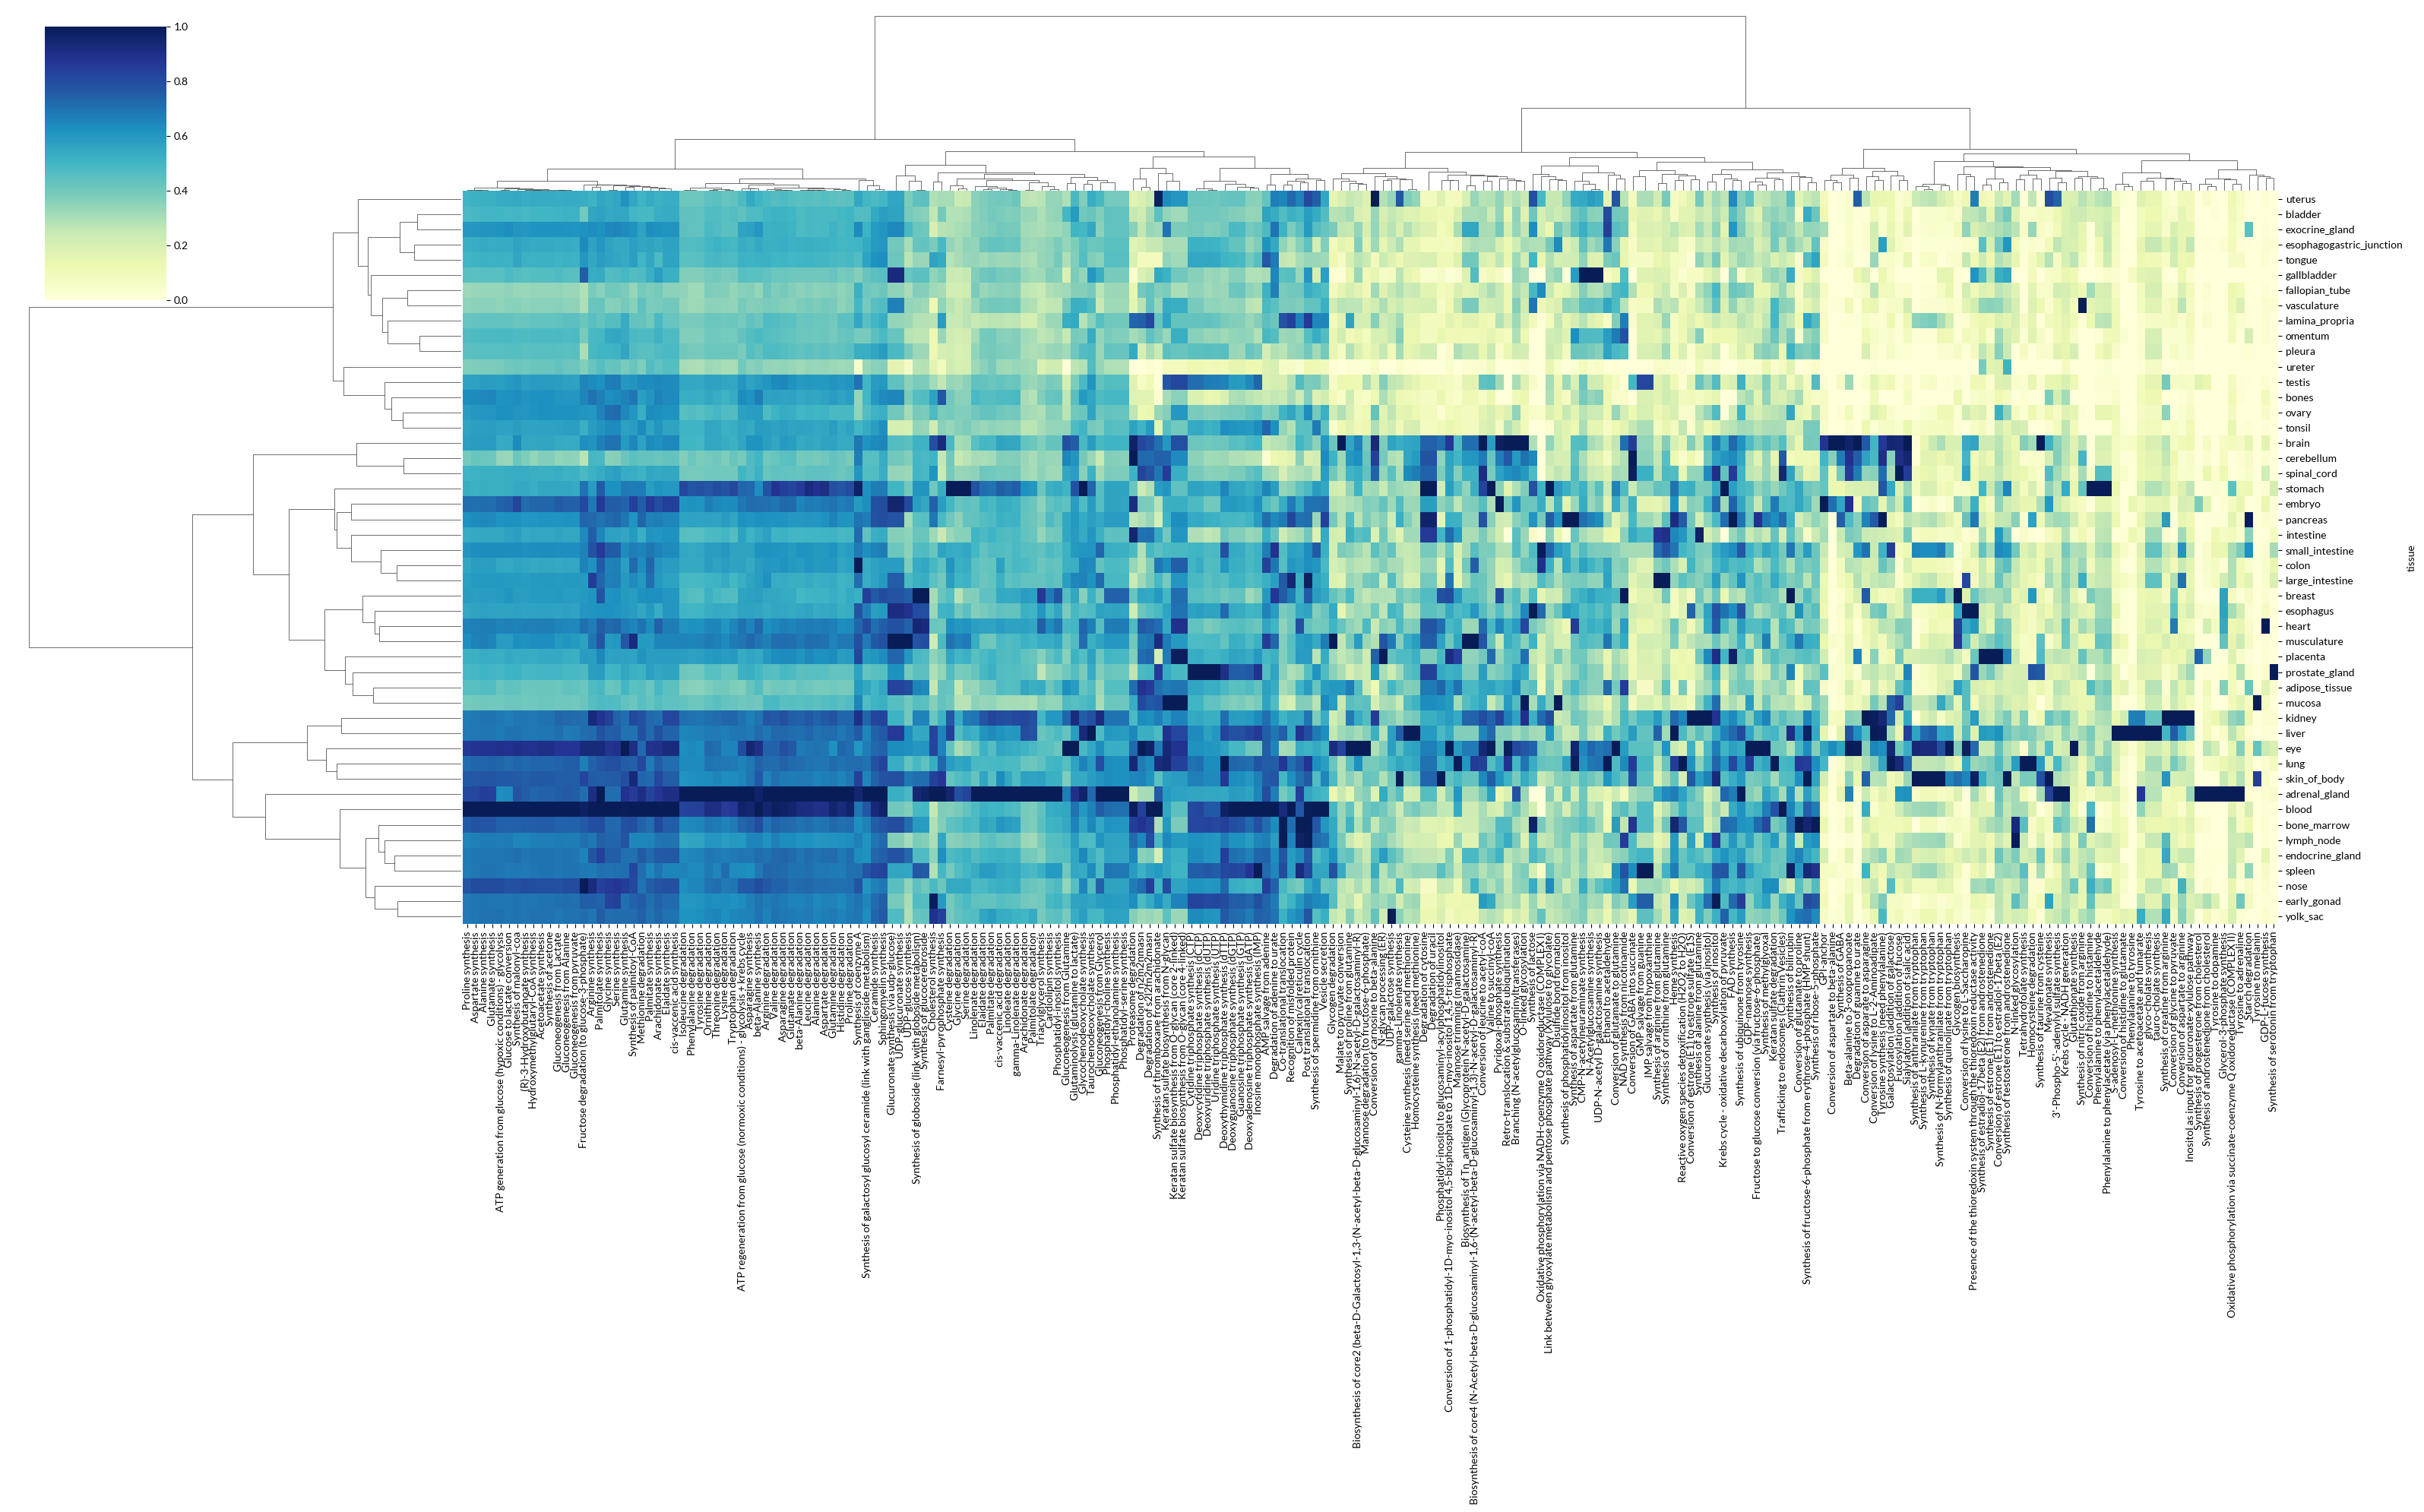

In [21]:
sns.clustermap(plot_df, method='ward', metric='euclidean', figsize=(32, 20),
               cmap='YlGnBu', yticklabels=1, xticklabels=1
              )

### Radial plot across organs

In [22]:
radial_df = plot_df.mean().to_frame().reset_index()
radial_df.columns = ['metabolic_task', 'avg']

In [23]:
sccellfie_db = sccellfie.datasets.load_sccellfie_database()
task_info = sccellfie_db['task_info']
task_dict = dict(zip(task_info['Task'].values.tolist(), task_info['System'].values.tolist()))

In [24]:
radial_df['category'] = radial_df['metabolic_task'].map(task_dict)

In [25]:
radial_df

metabolic_task       avg  \
0                     (R)-3-Hydroxybutanoate synthesis  0.589113   
1             3'-Phospho-5'-adenylyl sulfate synthesis  0.237012   
2                             AMP salvage from adenine  0.571107   
3    ATP generation from glucose (hypoxic condition...  0.587848   
4    ATP regeneration from glucose (normoxic condit...  0.582562   
..                                                 ...       ...   
213                        cis-vaccenic acid synthesis  0.624897   
214                       gamma-Linolenate degradation  0.472752   
215                         gamma-Linolenate synthesis  0.347065   
216                            glyco-cholate synthesis  0.220459   
217                            tauro-cholate synthesis  0.220459   

                     category  
0    CARBOHYDRATES METABOLISM  
1       NUCLEOTIDE METABOLISM  
2       NUCLEOTIDE METABOLISM  
3           ENERGY METABOLISM  
4           ENERGY METABOLISM  
..                        ...  
213         LIPIDS METABOLISM  
214         LIPIDS METABOLISM  
215         LIPIDS METABOLISM  
216         LIPIDS METABOLISM  
217         LIPIDS METABOLISM  

[218 rows x 3 columns]

In [27]:
def add_pathway_annotations(pathway_list, data_df, ax, text_dist_factor=1.15):
    """
    Add arrows and text annotations for specified pathways
    
    Parameters:
    -----------
    pathway_list : list
        List of pathway names to annotate
    data_df : DataFrame
        DataFrame containing pathway data with angles and Fraction values
    ax : matplotlib axis
        The polar axis to add annotations to
    text_dist_factor : float
        Factor to multiply radius for text distance (controls how far out the text appears)
    """
    for pathway in pathway_list:
        # Find the pathway in the dataframe
        pathway_row = data_df[data_df['Pathway'] == pathway]
        
        if len(pathway_row) == 0:
            print(f"Warning: Pathway '{pathway}' not found in data")
            continue
            
        # Extract angle and radius (fraction)
        angle = pathway_row['angle'].values[0]
        radius = pathway_row['Fraction'].values[0]
        
        # Calculate text position (further out from the bar end)
        text_radius = radius * text_dist_factor
        
        # Determine text alignment based on position in the circle
        ha = 'left'
        if np.cos(angle) < 0:
            ha = 'right'
            
        # Set vertical alignment based on position
        if np.sin(angle) > 0:
            va = 'bottom'
        else:
            va = 'top'
            
        # Add the arrow and text annotation
        ax.annotate(
            pathway,
            xy=(angle, radius),  # Arrow starts at bar end
            xytext=(angle, text_radius),  # Text positioned beyond bar
            textcoords='data',
            ha=ha, va=va,
            fontsize=8, fontweight='bold',
            rotation=0,  # Keep text horizontal
            arrowprops=dict(
                arrowstyle='->',
                color='lightgray',
                linewidth=1,
                linestyle='--'
            )
        )

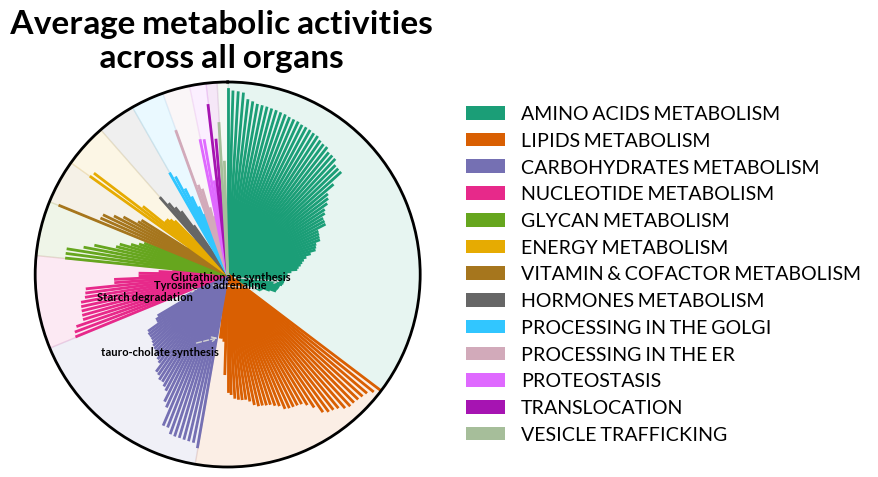

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glasbey  # Make sure this library is installed

# Rename the columns to match the original code's expected names
radial_df = radial_df.rename(columns={'metabolic_task': 'Pathway', 'avg': 'Fraction', 'category': 'Category'})

# Get unique categories ordered by count (descending)
category_counts = radial_df['Category'].value_counts()
categories_by_size = category_counts.index.tolist()  # Categories ordered by descending count

# Update this line based on what task_info contains in your environment
palette = glasbey.extend_palette('Dark2', palette_size=len(categories_by_size))

# Assign colors based on the size-ordered categories (not alphabetically)
color_map = {cat: palette[i] for i, cat in enumerate(categories_by_size)}

# Create a single figure
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='polar')

ylim = radial_df.Fraction.max() # 1.0

# Since we don't have Cell Type for pivoting, we'll use the Fraction values directly
# Each pathway should only appear once in the new dataframe with its avg value
# Create a Series indexed by Pathway with Fraction values
max_scores = radial_df.set_index('Pathway')['Fraction']

# Create a DataFrame with pathway and category information
pathway_info = radial_df[['Pathway', 'Category']].drop_duplicates()

# Merge the max scores with the pathway information - max_scores is already indexed by Pathway
pathway_data = pd.merge(max_scores.reset_index(), pathway_info, on='Pathway')

# Sort by number of pathways per category (descending), then by avg/Fraction (descending)
# Count the number of pathways in each category
category_counts = radial_df['Category'].value_counts()

# Add this count to each pathway
pathway_data['category_count'] = pathway_data['Category'].map(category_counts)

# Sort by category count (descending), then by Fraction (descending)
pathway_data = pathway_data.sort_values(['category_count', 'Fraction'], ascending=[False, False])

# Drop the temporary column
pathway_data = pathway_data.drop(columns=['category_count'])

pathways = pathway_data['Pathway'].tolist()
max_scores = pathway_data['Fraction'].tolist()  # Changed from pathway_data[0]
categories = pathway_data['Category'].tolist()

# Get categories in the order determined by our sorting
categories_ordered = pathway_data['Category'].unique()

# Count pathways in each category
category_counts = {}
for cat in categories_ordered:
    category_counts[cat] = pathway_data[pathway_data['Category'] == cat].shape[0]

# Calculate angle for each pathway
total_pathways = len(pathway_data)
angle_per_pathway = (2 * np.pi) / total_pathways

# Initialize for angle assignment
angles = []
pathway_data_grouped = []
current_angle = 0

# Process each category in our determined order
for category in categories_ordered:
    # Record the starting angle for this category
    category_start_angle = current_angle
    
    # Get data for this category, preserving the original sort within the category
    category_data = pathway_data[pathway_data['Category'] == category].copy()
    
    # Create a range of angles for this category
    num_pathways = len(category_data)
    category_angles = np.linspace(current_angle, 
                                  current_angle + (num_pathways * angle_per_pathway), 
                                  num_pathways, 
                                  endpoint=False)
    
    # Assign these angles
    category_data['angle'] = category_angles
    
    # Add to our main dataframe
    angles.extend(category_angles)
    
    # Update current angle for the next category
    current_angle += num_pathways * angle_per_pathway
    
    # Store category boundary
    pathway_data_grouped.append({
        'category': category,
        'start_angle': category_start_angle,
        'end_angle': current_angle,
        'data': category_data
    })

# Create a new dataframe with all the angle-assigned data
new_pathway_data = pd.concat([group_info['data'] for group_info in pathway_data_grouped])

# Use this new dataframe for plotting
pathway_data = new_pathway_data

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Set the y-axis limit based on the maximum score across all pathways
ax.set_ylim(0, ylim)

# Add the axis from the center
ax.spines['polar'].set_visible(True)
ax.spines['polar'].set_linewidth(2)
ax.spines['polar'].set_color('black')

# Set the position of the score ticks
ax.set_rlabel_position(180)  # Adjust the angle (in degrees) to move the ticks
ax.set_yticks([np.min([1., ylim]), ylim])
ax.set_yticklabels(['', ''], fontsize=16)
ax.tick_params(axis='y', which='major', width=1., color='red')

# Color the circular area behind each category with exact alignment
for group_info in pathway_data_grouped:
    category = group_info['category']
    start_angle = group_info['start_angle']
    end_angle = group_info['end_angle']
    
    # Create angles that span exactly from the first to last pathway in this category
    cat_angles = np.linspace(start_angle, end_angle, 50)
    
    # Fill the background
    ax.fill_between(cat_angles, 0, ylim, color=color_map[category], alpha=0.1, zorder=0)

# Plot the data on the radial plot with connected bars within each category
# Group by category
for group_info in pathway_data_grouped:
    category = group_info['category']
    
    # Get all pathways in this category
    category_paths = pathway_data[pathway_data['Category'] == category]
    
    # Get angles and scores for this category
    cat_angles = category_paths['angle'].values
    cat_scores = category_paths['Fraction'].values
    
    # For each pathway in the category, draw the radial line
    for angle, score in zip(cat_angles, cat_scores):
        ax.plot([angle, angle], [0, score], color=color_map[category], linewidth=2)
    
    # Connect all bars within this category with a polygon
    # First, create pairs of points at the base and top of each bar
    polygon_angles = []
    polygon_radii = []
    
    # Start the polygon at the first bar, at the base
    for angle, score in zip(cat_angles, cat_scores):
        # Add a point at the base (radius 0)
        polygon_angles.append(angle)
        polygon_radii.append(0)
        
        # Add a point at the top of the bar
        polygon_angles.append(angle)
        polygon_radii.append(score)
    
    # Convert to numpy arrays for matplotlib
    polygon_angles = np.array(polygon_angles)
    polygon_radii = np.array(polygon_radii)
    
    # Plot the polygon
    ax.fill(polygon_angles, polygon_radii, color=color_map[category], alpha=0.25)

ax.set_xticks([])

# Create a single legend using the same category order as the colors (by size)
legend_labels = categories_by_size  # Use the same ordered categories we defined earlier
legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color_map[cat], lw=0) for cat in legend_labels]
legend_labels = [l.upper() for l in legend_labels]

# Calculate the number of columns and rows for the legend
num_legend_cols = 1
num_legend_rows = (len(legend_labels) + num_legend_cols - 1) // num_legend_cols

# Create the legend handles and labels in the desired order
legend_handles_horizontal = []
legend_labels_horizontal = []
for i in range(num_legend_cols):
    legend_handles_horizontal.extend(legend_handles[i:len(legend_labels):num_legend_cols])
    legend_labels_horizontal.extend(legend_labels[i:len(legend_labels):num_legend_cols])

ax.legend(legend_handles_horizontal, legend_labels_horizontal,
          loc="center left", bbox_to_anchor=(1.1, 0.5),
          fontsize=14, frameon=False, borderaxespad=0,
          ncol=num_legend_cols
         )

plt.suptitle('Average metabolic activities\nacross all organs', fontsize=24, fontweight='bold', y=1.025)
plt.savefig('./Paper-Figures/CELLxGENE-Radial_Plot.pdf', dpi=300, bbox_inches='tight')

# List of pathways you want to annotate
pathways_to_annotate = ['Glutathionate synthesis',
                        'Starch degradation',
                        'tauro-cholate synthesis',
                        'Tyrosine to adrenaline',
                    ]

# Add annotations to the plot
add_pathway_annotations(pathways_to_annotate, pathway_data, ax)

plt.savefig('./Paper-Figures/CELLxGENE-Radial_Plot_Annotated.pdf', dpi=300, bbox_inches='tight')

In [32]:
df = pathway_data.reset_index(drop=True)
df.loc[df.Pathway == 'Glutathionate synthesis']

Pathway  Fraction                Category     angle
59  Glutathionate synthesis  0.194473  AMINO ACIDS METABOLISM  1.700495

### Visualize specific tasks

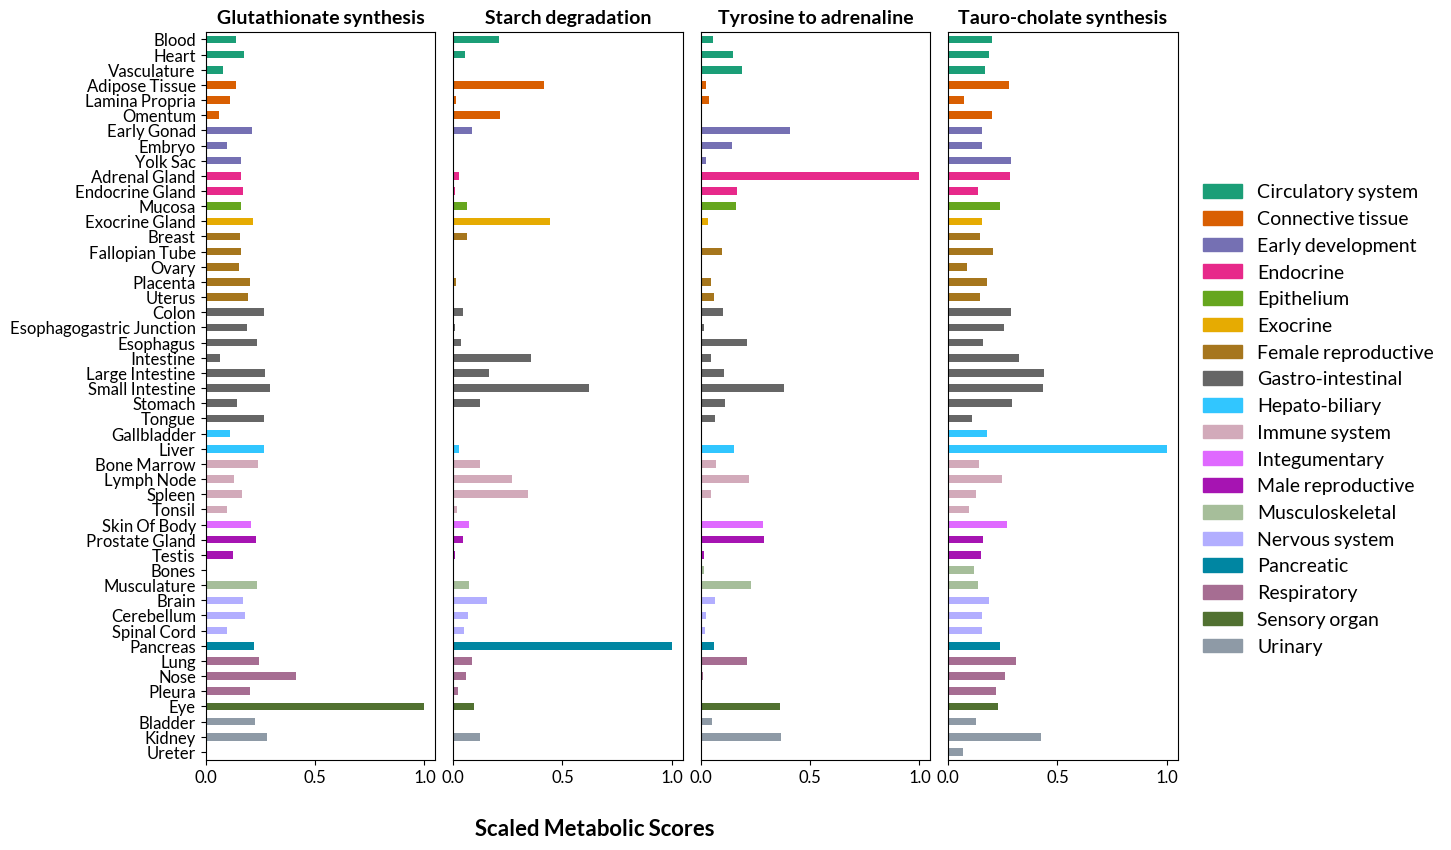

In [33]:
tasks_plot = sorted(['Glutathionate synthesis',
                     'Starch degradation',
                     'tauro-cholate synthesis',
                     'Tyrosine to adrenaline',
                    ])

fig, axes = create_multi_bar_plots(plot_df, tasks_plot, ylabel ='', label_dict=label_map, palette='Dark2', 
                                   subplot_title_fontsize=14,
                                   unified_xlabel=True, unified_xlabel_fontsize=16,
                                   xlabels='Scaled Metabolic Scores', legend_position=(1., 0.5), legend_fontsize=14,
                                   savefig_path='{}/CELLxGENE-Task-to-Show.pdf'.format(sc.settings.figdir)
                                  )

In [34]:
cellxgene[(cellxgene.metabolic_task == 'Glutathionate synthesis') & (cellxgene.tissue == 'eye')].sort_values('trimean', ascending=False).head(5)
# & (cellxgene.tissue == 'eye')

metabolic_task tissue             cell_type   trimean  \
177318  Glutathionate synthesis    eye       lens fiber cell  2.815800   
181896  Glutathionate synthesis    eye     radial glial cell  0.679444   
167290  Glutathionate synthesis    eye    H1 horizontal cell  0.527148   
184730  Glutathionate synthesis    eye             stem cell  0.516024   
184076  Glutathionate synthesis    eye  secondary lens fiber  0.450675   

        scaled_trimean  variance       std  n_cells_threshold  \
177318        1.000000  2.245005  1.498334              366.0   
181896        0.241297  0.254888  0.504864                1.0   
167290        0.187211  0.326946  0.571792                7.0   
184730        0.183260  0.186289  0.431612                0.0   
184076        0.160052  0.208751  0.456892                0.0   

        n_cells_nonzero  total_cells          label Tissue  
177318           1033.0         1033  Sensory organ    Eye  
181896            195.0          195  Sensory organ    Eye  
167290           7275.0         7297  Sensory organ    Eye  
184730            144.0          144  Sensory organ    Eye  
184076           1677.0         1677  Sensory organ    Eye

In [35]:
cellxgene.groupby(['tissue', 'cell_type'])['total_cells'].agg('min').groupby('tissue').sum().sort_values(ascending=False)

tissue
brain                       10560407
blood                        4938062
breast                       2280877
eye                          2208042
lung                         1511828
heart                         791314
liver                         748399
skin_of_body                  496686
kidney                        491361
small_intestine               454019
adrenal_gland                 437538
endocrine_gland               397767
placenta                      373758
early_gonad                   364425
spleen                        360993
bone_marrow                   296455
adipose_tissue                252078
colon                         216197
lymph_node                    206676
nose                          196274
embryo                        165823
pancreas                      165797
esophagus                     159747
fallopian_tube                126841
large_intestine               126021
uterus                        123144
musculature                   1

## UMAP visualizatons

**Test**

In [36]:
tissue = 'adrenal_gland'
results_dir = f'/lustre/scratch126/cellgen/team292/eg22/CELLxGENE/Run-sccellfie-V0_4_2-snapshot-Apr24/{tissue}/'
task = 'Tyrosine to adrenaline'

In [37]:
with open(f'{results_dir}/cell_type_mapping.json', mode='r') as fp:
    cell_dict = json.load(fp)

In [38]:
tissue_cts = cellxgene.loc[cellxgene.tissue == tissue]['cell_type'].astype(str).unique()
for i, ct in tqdm(enumerate(tissue_cts), total=len(tissue_cts)):
    mt_df = pd.read_csv('{}/MT_dataframe_{}.csv'.format(results_dir, cell_dict[ct]), index_col=0)
    scaled_mt_df = mt_df.divide(min_max.loc['single_cell_max', mt_df.columns])
    metadata = pd.DataFrame(index=scaled_mt_df.index)
    metadata['celltype'] = ct
    if i == 0:
        mt_adata = sc.AnnData(X=scaled_mt_df, obs=metadata)
    else:
        mt_adata = ad.concat([mt_adata, sc.AnnData(X=scaled_mt_df, obs=metadata)], join='outer')
mt_adata.X[np.isnan(mt_adata.X)] = 0

100%|██████████| 41/41 [00:41<00:00,  1.01s/it]


In [39]:
mt_adata.shape

(437538, 218)

In [40]:
umap = pd.read_csv('./Embeddings/adrenal_gland_UMAP.csv', index_col=0)

In [41]:
mt_adata.obsm['X_umap'] = umap.loc[mt_adata.obs.index].values

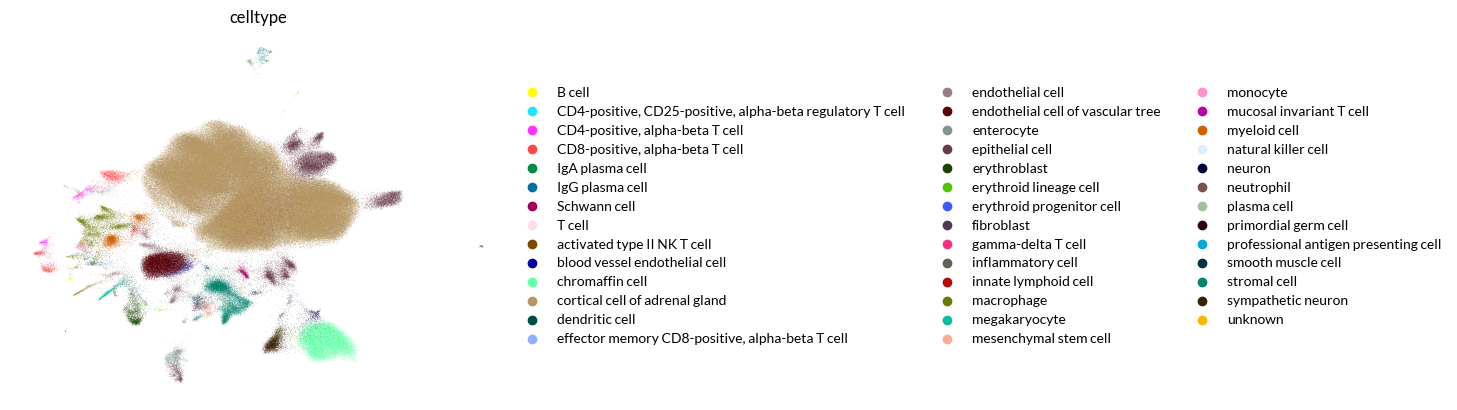

In [42]:
sc.pl.umap(mt_adata, color=['celltype'], ncols=1, use_raw=False, frameon=False, #save=f'_{tissue}_celltype'
          )

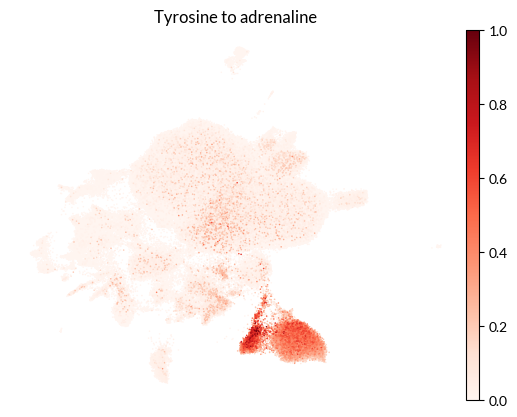

In [43]:
sc.pl.umap(mt_adata, color=[task], ncols=1, use_raw=False, frameon=False, cmap='Reds', vmax=1, size=5, #save=f'_{tissue}_task'
          )

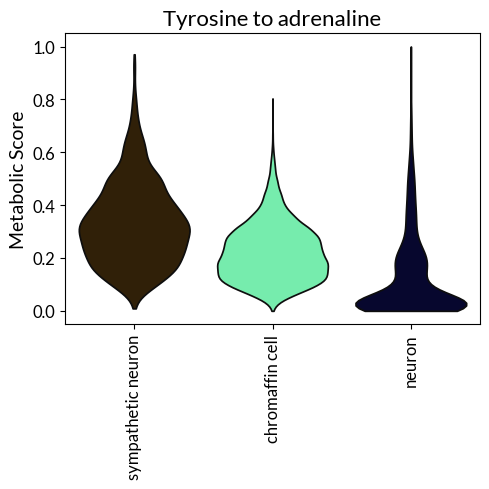

In [44]:
celltypes = cellxgene[(cellxgene.metabolic_task == task) & (cellxgene.tissue == tissue)].sort_values('trimean', ascending=False).head(3).cell_type.values.tolist()

fig, axes = sccellfie.plotting.create_multi_violin_plots(mt_adata,
                                                 features=[task],
                                                 groupby='celltype',
                                                 n_cols=1,
                                                 order=celltypes,
                                                 stripplot=False,
                                                 fontsize=12,
                                                 wrapped_title_length=45,
                                                 w_pad=None,
                                                 ylabel='Metabolic Score',
                                                 #save=f'{tissue}_task_{j}.pdf',
                                                 )

**Tissues and tasks of interest**

In [45]:
def identify_celltypes(adata, feature_name, threshold=0.5):
    # Find the index of the feature in var_names
    if feature_name in adata.var_names:
        feature_index = adata.var_names.get_loc(feature_name)
    else:
        raise ValueError(f"Feature '{feature_name}' not found in adata.var_names")

    # Extract the feature values for all cells
    if isinstance(adata.X, np.ndarray):
        feature_values = adata.X[:, feature_index]
    else:  # For sparse matrices
        feature_values = adata.X[:, feature_index].toarray().flatten()

    # Create a boolean mask for cells above the threshold
    mask = feature_values > threshold

    # Get the cell types of cells that pass the threshold
    cell_types_above_threshold = adata.obs.loc[mask, 'celltype'].unique()

    print(f"Cell types with {feature_name} > {threshold}:")
    for cell_type in cell_types_above_threshold:
        print(f"- {cell_type}")

    # Optional: Get count per cell type
    cell_type_counts = adata.obs.loc[mask, 'celltype'].value_counts()
    print("\nCount of cells above threshold by cell type:")
    print(cell_type_counts.head(10))
    return cell_type_counts.head(3).index.tolist()

100%|██████████| 41/41 [00:30<00:00,  1.36it/s]


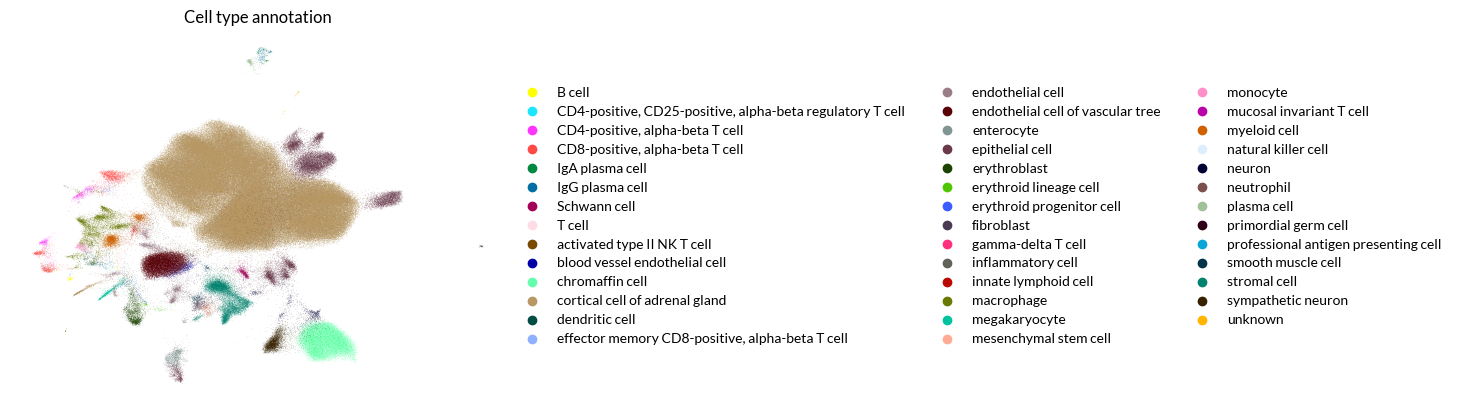

Cell types with Tyrosine to adrenaline > 0.4:
- chromaffin cell
- cortical cell of adrenal gland
- neuron
- sympathetic neuron

Count of cells above threshold by cell type:
celltype
chromaffin cell                   1343
sympathetic neuron                1140
neuron                             108
cortical cell of adrenal gland       6
natural killer cell                  0
innate lymphoid cell                 0
macrophage                           0
megakaryocyte                        0
mesenchymal stem cell                0
monocyte                             0
Name: count, dtype: int64


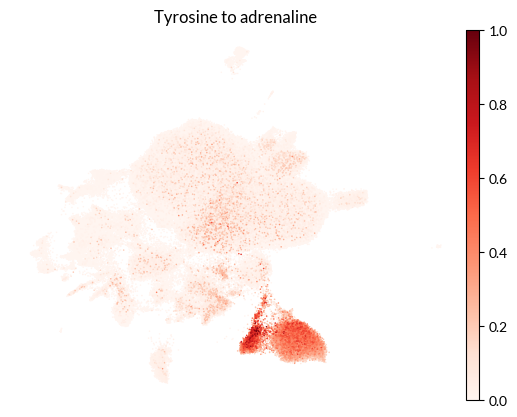

100%|██████████| 87/87 [04:15<00:00,  2.94s/it]


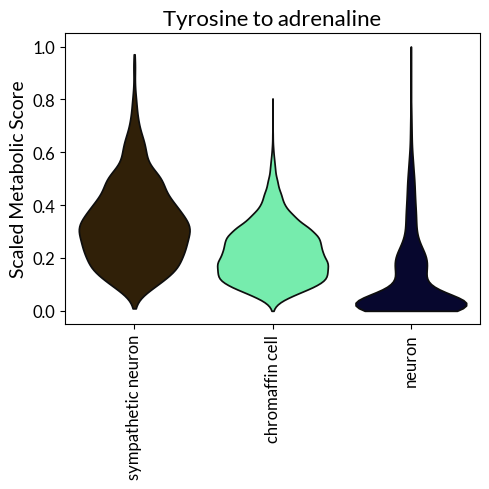

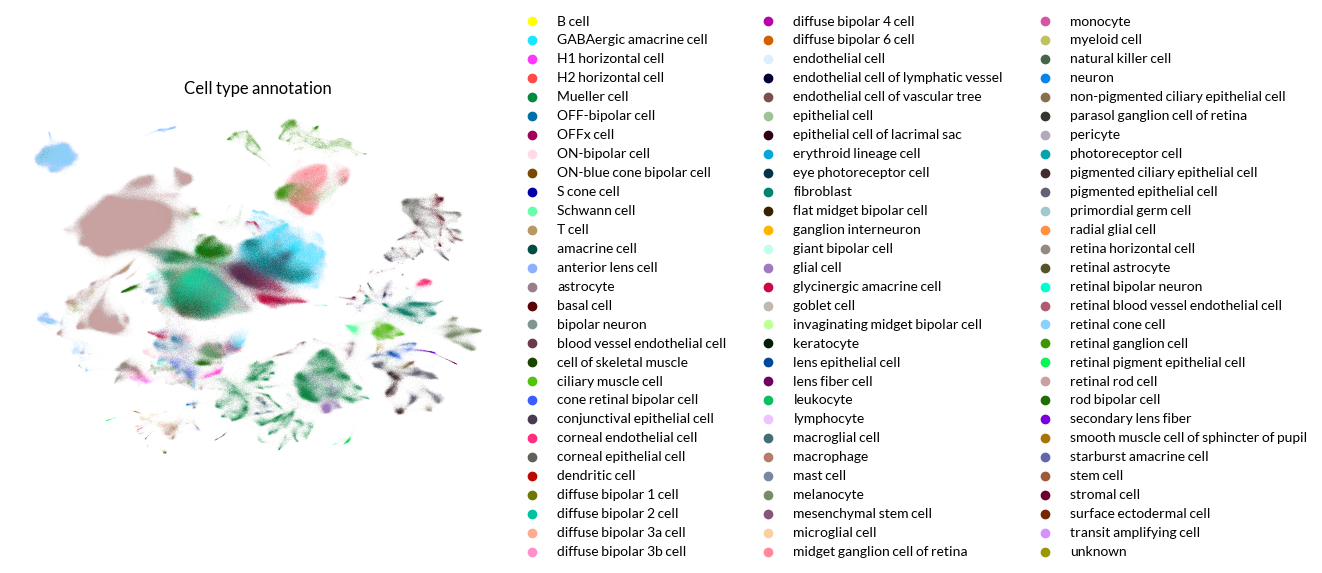

Cell types with Glutathionate synthesis > 0.4:
- GABAergic amacrine cell
- Mueller cell
- OFF-bipolar cell
- amacrine cell
- astrocyte
- basal cell
- bipolar neuron
- cell of skeletal muscle
- cone retinal bipolar cell
- diffuse bipolar 4 cell
- epithelial cell
- flat midget bipolar cell
- ganglion interneuron
- giant bipolar cell
- lens fiber cell
- macroglial cell
- mesenchymal stem cell
- neuron
- photoreceptor cell
- retina horizontal cell
- retinal bipolar neuron
- retinal blood vessel endothelial cell
- retinal ganglion cell
- retinal pigment epithelial cell
- retinal rod cell
- rod bipolar cell
- stromal cell

Count of cells above threshold by cell type:
celltype
retinal rod cell          70
lens fiber cell           64
retinal ganglion cell     62
Mueller cell              61
photoreceptor cell        59
amacrine cell             29
macroglial cell           22
retinal bipolar neuron    10
stromal cell               7
retina horizontal cell     6
Name: count, dtype: int64


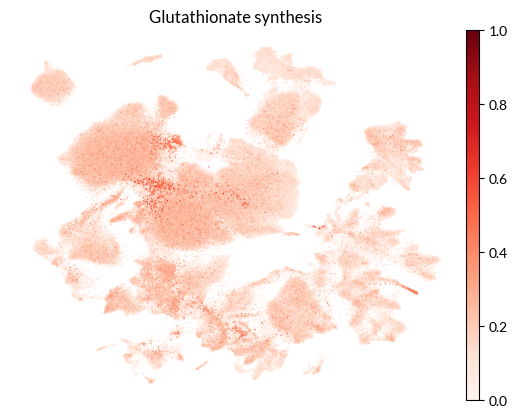

100%|██████████| 99/99 [01:32<00:00,  1.07it/s]


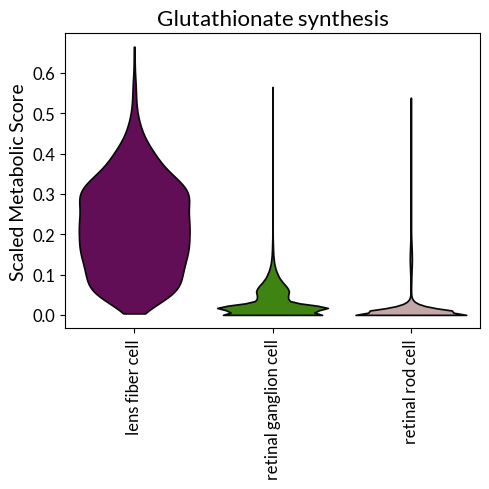

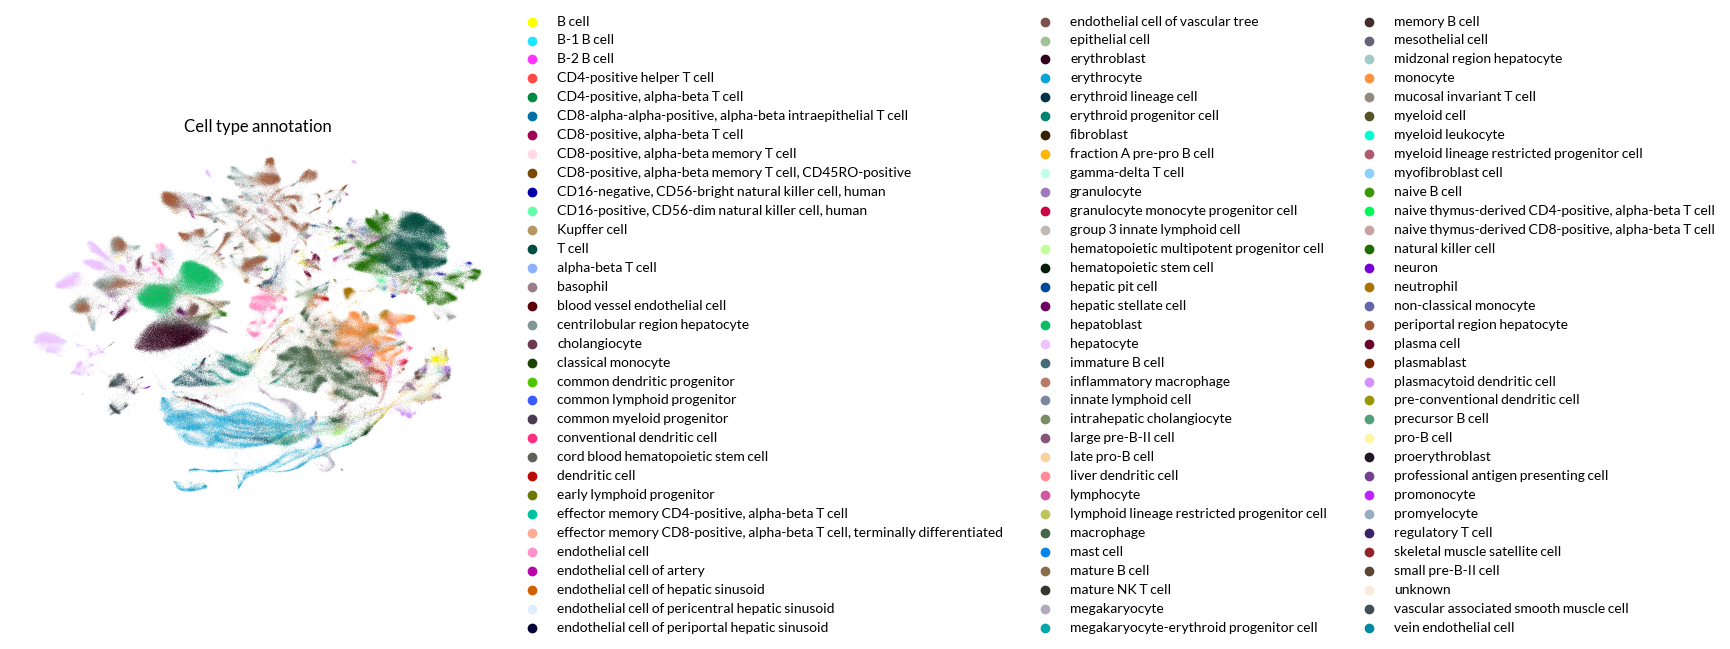

Cell types with tauro-cholate synthesis > 0.4:
- B cell
- CD4-positive, alpha-beta T cell
- CD8-positive, alpha-beta T cell
- Kupffer cell
- T cell
- blood vessel endothelial cell
- centrilobular region hepatocyte
- cholangiocyte
- dendritic cell
- endothelial cell
- endothelial cell of hepatic sinusoid
- endothelial cell of pericentral hepatic sinusoid
- endothelial cell of periportal hepatic sinusoid
- endothelial cell of vascular tree
- epithelial cell
- erythroblast
- erythroid lineage cell
- fibroblast
- hepatic pit cell
- hepatic stellate cell
- hepatoblast
- hepatocyte
- inflammatory macrophage
- intrahepatic cholangiocyte
- liver dendritic cell
- lymphocyte
- macrophage
- mature B cell
- mature NK T cell
- megakaryocyte
- midzonal region hepatocyte
- monocyte
- myeloid cell
- natural killer cell
- periportal region hepatocyte
- plasmablast
- unknown
- vascular associated smooth muscle cell
- vein endothelial cell

Count of cells above threshold by cell type:
celltype
hepatocyte

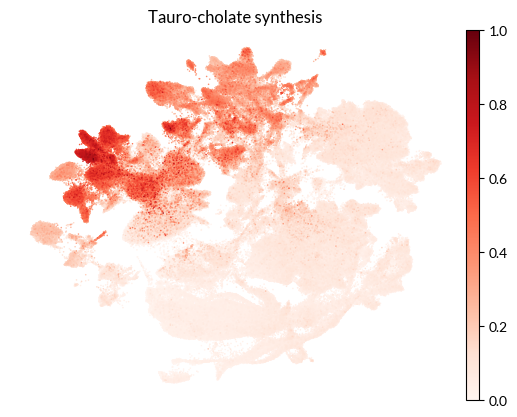

Cell types with Glutathionate synthesis > 0.4:
- B cell
- Kupffer cell
- T cell
- centrilobular region hepatocyte
- cholangiocyte
- cord blood hematopoietic stem cell
- dendritic cell
- endothelial cell
- endothelial cell of pericentral hepatic sinusoid
- endothelial cell of vascular tree
- epithelial cell
- erythroblast
- erythroid lineage cell
- erythroid progenitor cell
- fibroblast
- hematopoietic multipotent progenitor cell
- hematopoietic stem cell
- hepatic stellate cell
- hepatoblast
- hepatocyte
- inflammatory macrophage
- innate lymphoid cell
- lymphocyte
- macrophage
- mast cell
- mature NK T cell
- megakaryocyte
- mesothelial cell
- midzonal region hepatocyte
- monocyte
- myeloid cell
- natural killer cell
- neutrophil
- periportal region hepatocyte
- plasma cell
- unknown

Count of cells above threshold by cell type:
celltype
erythroblast                         873
hepatoblast                          335
erythroid progenitor cell             45
periportal region hepatocy

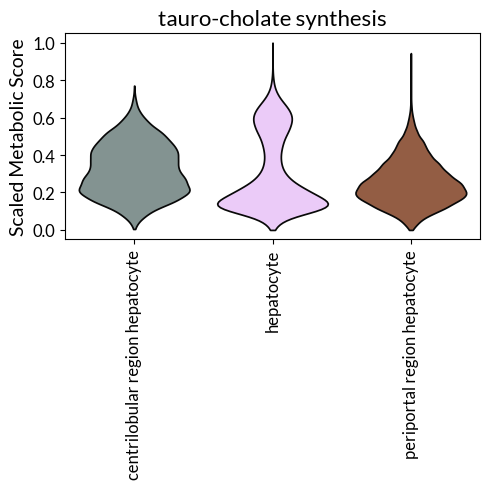

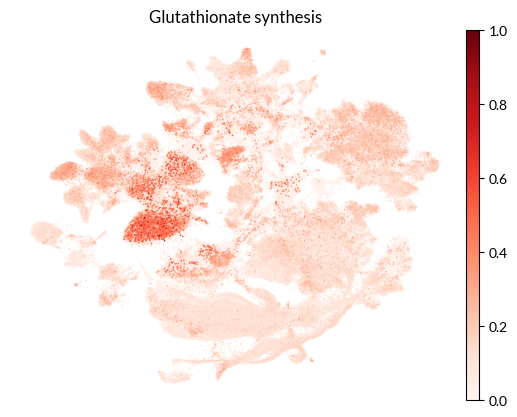

100%|██████████| 40/40 [00:14<00:00,  2.81it/s]


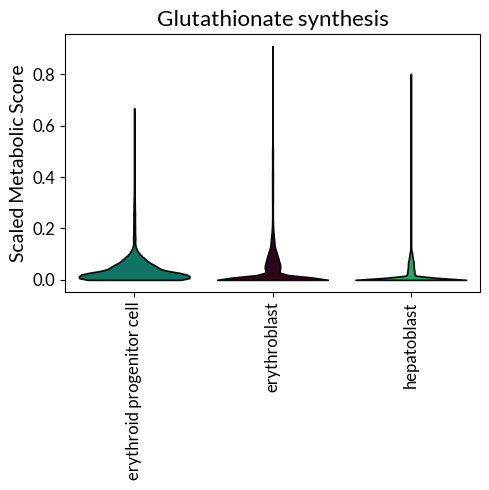

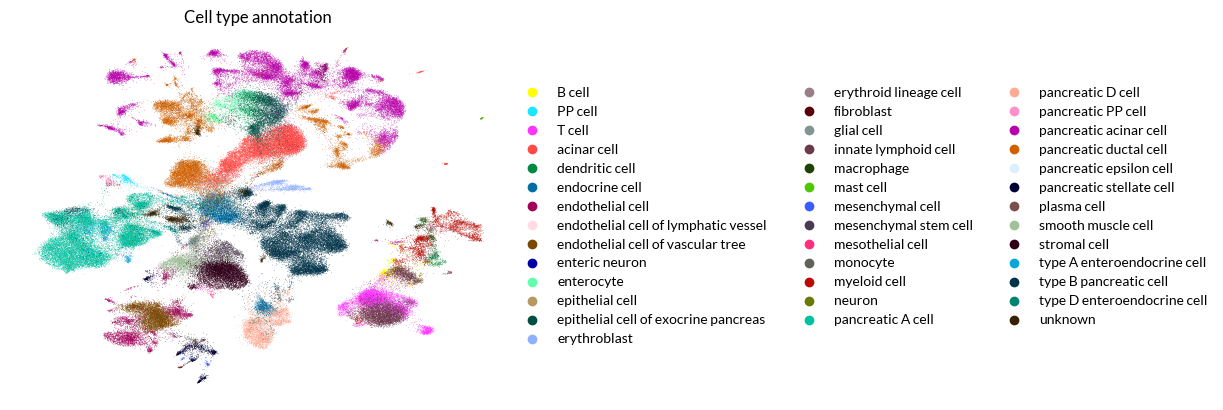

Cell types with Starch degradation > 0.4:
- acinar cell
- enterocyte
- epithelial cell of exocrine pancreas
- innate lymphoid cell
- pancreatic acinar cell
- unknown

Count of cells above threshold by cell type:
celltype
pancreatic acinar cell                  1903
epithelial cell of exocrine pancreas     640
acinar cell                              130
enterocyte                               100
innate lymphoid cell                       2
unknown                                    1
myeloid cell                               0
neuron                                     0
pancreatic A cell                          0
pancreatic D cell                          0
Name: count, dtype: int64


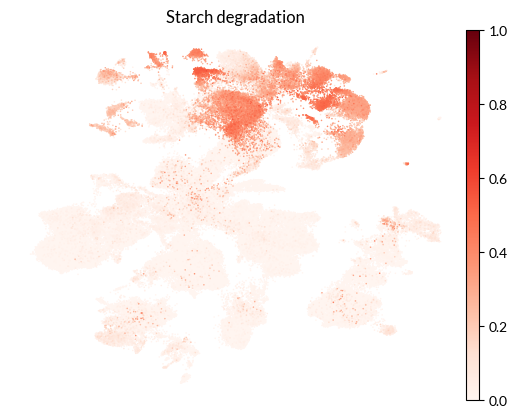

100%|██████████| 111/111 [00:55<00:00,  2.00it/s]


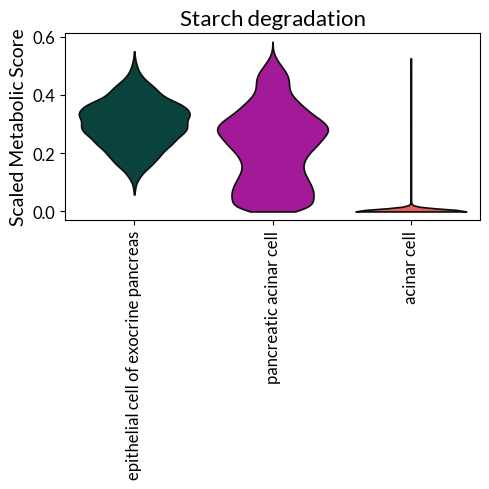

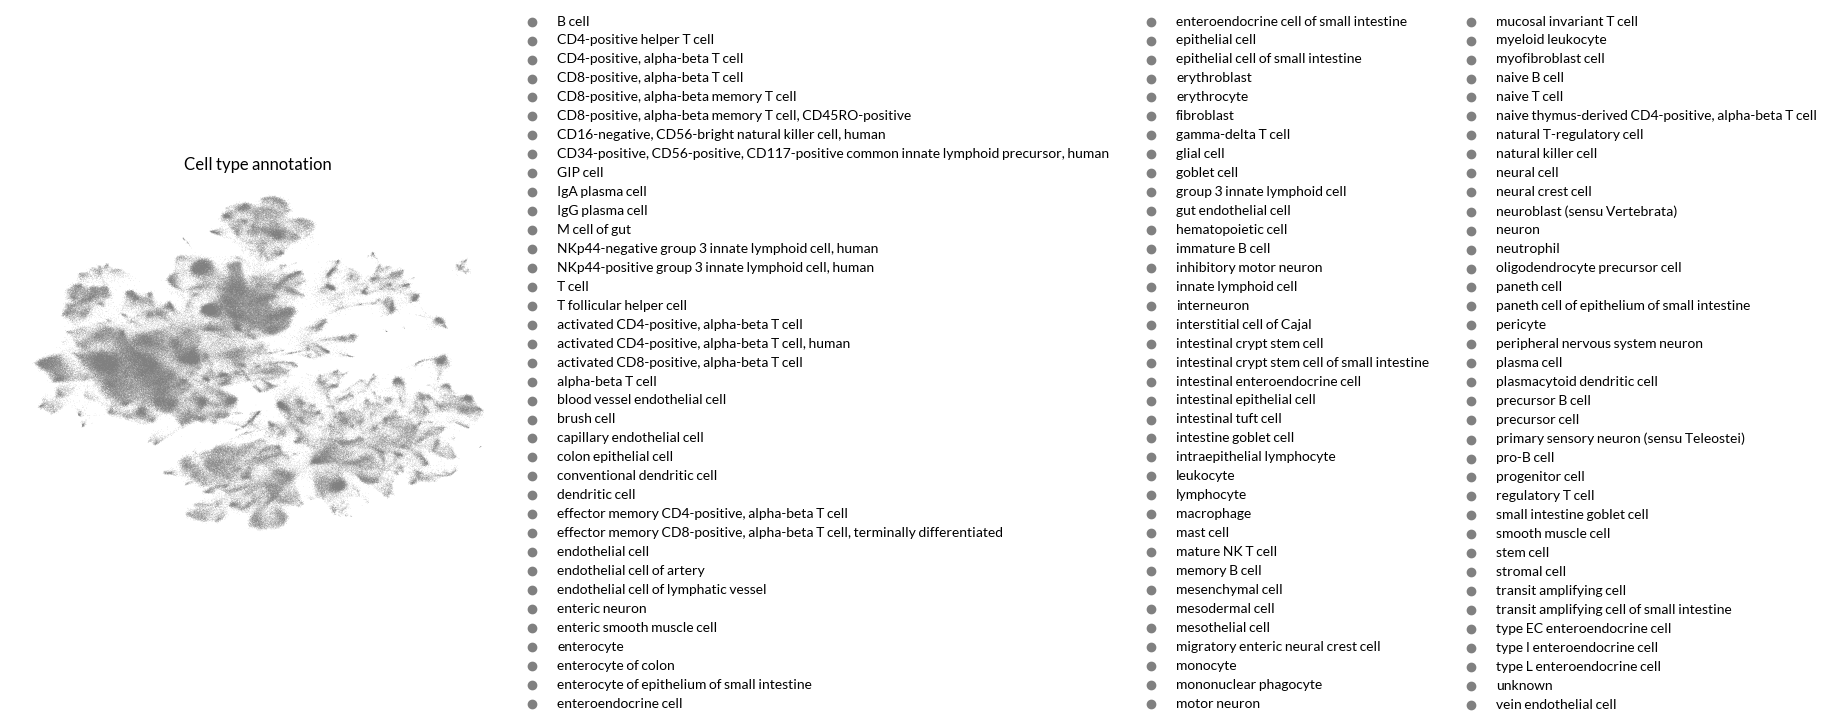

Cell types with Starch degradation > 0.4:
- T cell
- dendritic cell
- endothelial cell
- enterocyte
- enterocyte of colon
- enterocyte of epithelium of small intestine
- epithelial cell
- goblet cell
- mast cell
- paneth cell
- plasma cell
- stem cell
- stromal cell
- type L enteroendocrine cell

Count of cells above threshold by cell type:
celltype
enterocyte                                     2015
enterocyte of epithelium of small intestine     322
enterocyte of colon                              23
epithelial cell                                  22
stem cell                                        16
stromal cell                                     14
goblet cell                                       6
T cell                                            5
paneth cell                                       3
plasma cell                                       2
Name: count, dtype: int64


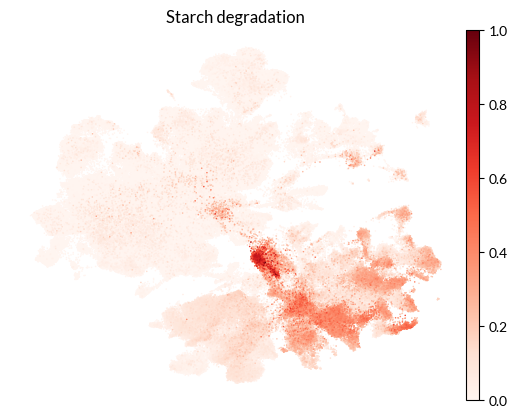

100%|██████████| 26/26 [00:10<00:00,  2.55it/s]


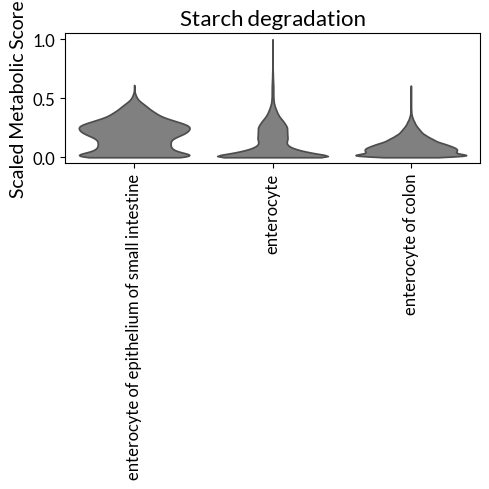

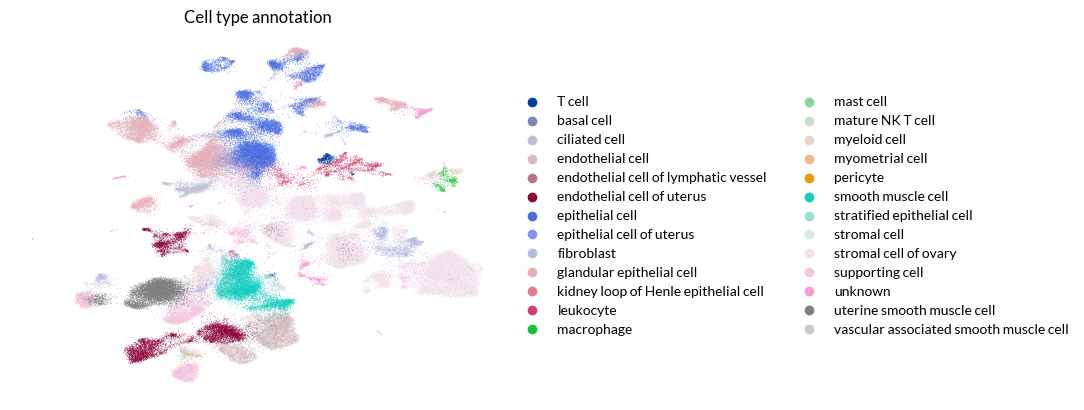

Cell types with Mevalonate synthesis > 0.4:
- basal cell
- endothelial cell
- epithelial cell
- epithelial cell of uterus
- glandular epithelial cell
- kidney loop of Henle epithelial cell
- leukocyte
- smooth muscle cell
- stratified epithelial cell
- stromal cell

Count of cells above threshold by cell type:
celltype
epithelial cell                         39
smooth muscle cell                      37
endothelial cell                        29
basal cell                               3
glandular epithelial cell                2
kidney loop of Henle epithelial cell     2
stromal cell                             2
epithelial cell of uterus                1
leukocyte                                1
stratified epithelial cell               1
Name: count, dtype: int64


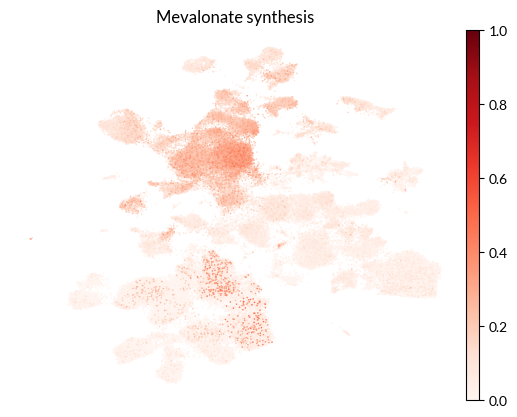

Cell types with Conversion of carnosine to beta-alanine > 0.4:
- T cell
- endothelial cell
- endothelial cell of uterus
- epithelial cell
- glandular epithelial cell
- kidney loop of Henle epithelial cell
- leukocyte
- mast cell
- smooth muscle cell
- stromal cell
- stromal cell of ovary
- supporting cell
- unknown

Count of cells above threshold by cell type:
celltype
epithelial cell               136
glandular epithelial cell      59
endothelial cell               46
smooth muscle cell             10
unknown                         6
endothelial cell of uterus      3
T cell                          2
leukocyte                       2
stromal cell                    2
supporting cell                 1
Name: count, dtype: int64


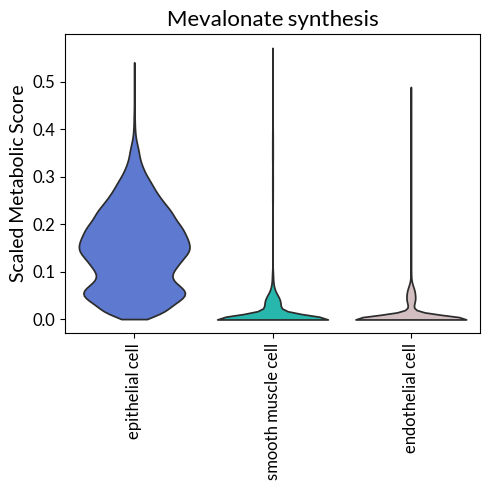

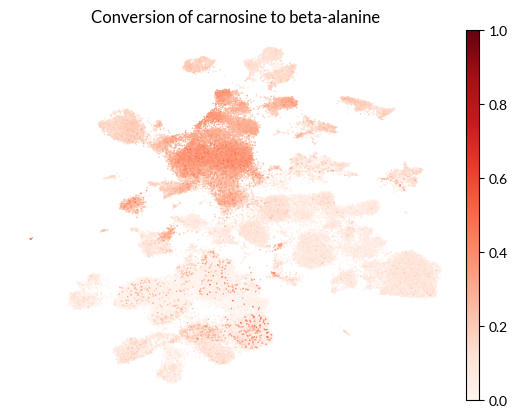

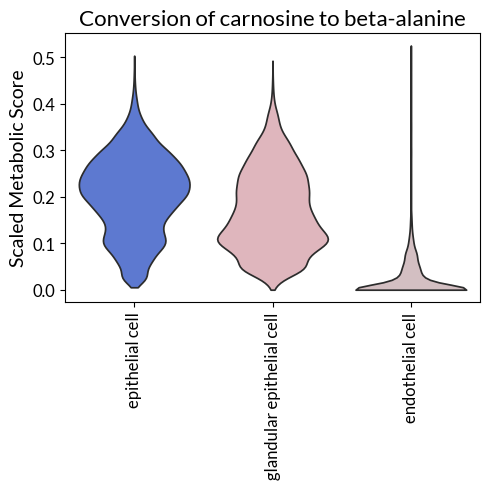

In [46]:
tissue_tasks = [('adrenal_gland', ['Tyrosine to adrenaline']),
                ('eye', ['Glutathionate synthesis']),
                ('liver', ['tauro-cholate synthesis', 'Glutathionate synthesis']),
                ('pancreas', ['Starch degradation']),
                ('small_intestine', ['Starch degradation']),
                ('uterus', ['Mevalonate synthesis', 'Conversion of carnosine to beta-alanine'])
               ]


for tissue, tasks in tissue_tasks:
    results_dir = f'/lustre/scratch126/cellgen/team292/eg22/CELLxGENE/Run-sccellfie-V0_4_2-snapshot-Apr24/{tissue}/'
    
    with open(f'{results_dir}/cell_type_mapping.json', mode='r') as fp:
        cell_dict = json.load(fp)
        
    tissue_cts = cellxgene.loc[cellxgene.tissue == tissue]['cell_type'].astype(str).unique()
    for i, ct in tqdm(enumerate(tissue_cts), total=len(tissue_cts)):
        mt_df = pd.read_csv('{}/MT_dataframe_{}.csv'.format(results_dir, cell_dict[ct]), index_col=0)
        scaled_mt_df = mt_df.divide(min_max.loc['single_cell_max', mt_df.columns])
        metadata = pd.DataFrame(index=scaled_mt_df.index)
        metadata['celltype'] = ct
        if i == 0:
            mt_adata = sc.AnnData(X=scaled_mt_df, obs=metadata)
        else:
            mt_adata = ad.concat([mt_adata, sc.AnnData(X=scaled_mt_df, obs=metadata)], join='outer')
    mt_adata.X[np.isnan(mt_adata.X)] = 0    
    umap = pd.read_csv(f'./Embeddings/{tissue}_UMAP.csv', index_col=0)
    
    mt_adata.obsm['X_umap'] = umap.loc[mt_adata.obs.index].values
    
    sc.pl.umap(mt_adata, color=['celltype'], ncols=1, use_raw=False, frameon=False, title='Cell type annotation', save=f'_{tissue}_celltype')
    for j, task in enumerate(tasks):
        celltypes = identify_celltypes(mt_adata, task, threshold=0.4)
        title = task[0].capitalize() + task[1:]
        sc.pl.umap(mt_adata, color=[task], ncols=1, use_raw=False, frameon=False, title=title, save=f'_{tissue}_task_{j}', cmap='Reds', vmax=1, size=5)
        
        #celltypes = cellxgene[(cellxgene.metabolic_task == task) & (cellxgene.tissue == tissue)].sort_values('trimean', ascending=False).head(3).cell_type.values.tolist()
        celltypes = cellxgene[(cellxgene.metabolic_task == task) & (cellxgene.tissue == tissue) & (cellxgene.cell_type.isin(celltypes))].sort_values('trimean', ascending=False).head(3).cell_type.values.tolist()

        fig, axes = sccellfie.plotting.create_multi_violin_plots(mt_adata,
                                                         features=[task],
                                                         groupby='celltype',
                                                         n_cols=1,
                                                         order=celltypes,
                                                         stripplot=False,
                                                         fontsize=12,
                                                         wrapped_title_length=45,
                                                         w_pad=None,
                                                         ylabel='Scaled Metabolic Score',
                                                         save=f'{tissue}_task_{j}.pdf',
                                                         )
    del mt_adata

In [47]:
cellxgene[cellxgene.metabolic_task == 'Testosterone from androstenedione']

Empty DataFrame
Columns: [metabolic_task, tissue, cell_type, trimean, scaled_trimean, variance, std, n_cells_threshold, n_cells_nonzero, total_cells, label, Tissue]
Index: []